In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
file_list=[
    {
        "vehicle_name": "Chrysler Pacifica 2018",
        "dbc_name": "opendbc/chrysler_pacifica_2017_hybrid.dbc",
        "steer_brake_acc": [258, 284, 308],
        "file_name": "exported_csvs/6fb4948a7ebe670e_2019-11-12--00-35-53.bz2.csv"
    },
    {
        "vehicle_name": "Toyota Prius Prime 2020",
        "dbc_name": "opendbc/toyota_prius_2017_pt_generated.dbc",
        "steer_brake_acc": [37, 166, 581], # acc input looks strange
        "file_name": "exported_csvs/eb378db0873da597_2020-02-29--11-50-42--0--rlog.bz2.csv"
    },
    {
        "vehicle_name": "Acura ILX",
        "dbc_name": "opendbc/acura_ilx_2016_can_generated.dbc",
        "steer_brake_acc": [342, 420, 304], # acc input looks strange
        "file_name": "exported_csvs/rlog.bz2.csv"
    },    
]

In [4]:
file_path = "exported_csvs/rlog.bz2.csv"
sequences = list()
df = pd.read_csv(file_path, header=0)
values = df.values

In [5]:
len(values)

10882

In [6]:
targets = np.ones(len(values))*342

In [7]:
targets

array([342., 342., 342., ..., 342., 342., 342.])

In [8]:
from sklearn import preprocessing

x = df.values #returns a numpy array
columns = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = columns

In [9]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [10]:
df

,145,342,398,399,819,821,304,316,344,380,...,888,923,773,985,929,1034,1029,1064,1365,busTime
0,0.517419,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.517419,0.999405,0.810548,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000090
2,0.517419,0.999405,0.810571,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000188
3,0.517419,0.999405,0.810571,0.002274,1.0,1.000000,5.800570e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000283
4,0.517419,0.999405,0.810501,0.002152,1.0,1.000000,5.881886e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10877,0.517135,0.999329,0.810432,0.993683,1.0,0.966322,3.936869e-03,0.000001,7.135548e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999628
10878,0.517135,0.999329,0.810432,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999716
10879,0.517135,0.999329,0.810455,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999811
10880,0.517135,0.999329,0.810455,0.993591,1.0,0.966322,3.952128e-03,0.000001,7.111097e-15,9.909291e-07,...,1.0,0.001432,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999911


In [185]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def create_X_y(df, num_samples, sample_length):
    X = np.zeros([num_samples, sample_length])
    y = np.zeros(num_samples)
    for i in range(num_samples):
        # Randomly choose which signal to write from
        signal_index = randint(0,df.shape[1]-1)
        chunk = []
        #print(signal_index)
        starting_point = randint(0,df.shape[0]-sample_length)
        
        for j in range(sample_length):
            # Since signal is very long, only a snippet is taken
            X[i][j] = df.iat[j+starting_point,signal_index]
            
        # Now create label based on what signal id we saved from    
        if df.columns[signal_index] in ["342"]: #steering value for acura ilx
            np.append(y,1)
            y[i]=1
        else:
            y[i]=0
    return [X,y]
    

X, y = create_X_y(df, 6000, 784)

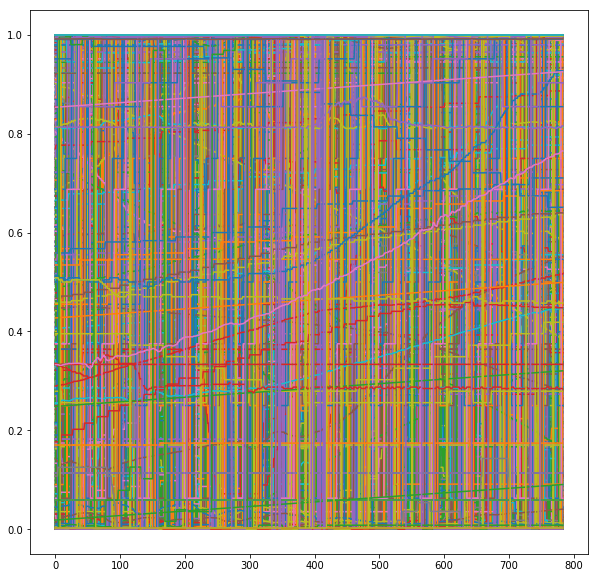

In [186]:
plt.figure(figsize=(10,10))
for i in range(0,X.shape[0]):
    plt.plot(X[i][:])
plt.show()

In [187]:
#y

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D
model = Sequential()
#model.add(Conv1D(10, 5, input_shape=(784,)))
model.add(Dense(50, activation="relu", input_shape=(784,)))
model.add(Dense(30, activation="relu", input_shape=(784,)))
model.add(Dense(10, activation="relu", input_shape=(784,)))

model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_41 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_42 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 11        
Total params: 41,101
Trainable params: 41,101
Non-trainable params: 0
_________________________________________________________________


In [200]:
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics = ["accuracy"])

In [201]:
y_train.shape

(4800,)

In [202]:
model.fit(X_train, y_train, batch_size=100, epochs=10)

Train on 4800 samples
Epoch 1/10
4800/4800 [==============================] - 0s 52us/sample - loss: 0.2930 - accuracy: 0.9417
Epoch 2/10
4800/4800 [==============================] - 0s 11us/sample - loss: 0.1260 - accuracy: 0.9875
Epoch 3/10
4800/4800 [==============================] - 0s 11us/sample - loss: 0.1155 - accuracy: 0.9875
Epoch 4/10
4800/4800 [==============================] - 0s 12us/sample - loss: 0.1113 - accuracy: 0.9875
Epoch 5/10
4800/4800 [==============================] - 0s 11us/sample - loss: 0.1084 - accuracy: 0.9875
Epoch 6/10
4800/4800 [==============================] - 0s 12us/sample - loss: 0.1059 - accuracy: 0.9875
Epoch 7/10
4800/4800 [==============================] - 0s 12us/sample - loss: 0.1037 - accuracy: 0.9875
Epoch 8/10
4800/4800 [==============================] - 0s 12us/sample - loss: 0.1016 - accuracy: 0.9875
Epoch 9/10
4800/4800 [==============================] - 0s 11us/sample - loss: 0.0997 - accuracy: 0.9875
Epoch 10/10
4800/4800 [==========

In [203]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1200/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [215]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def extract_random_sample(df, sample_length):
    x = np.zeros(sample_length)
    # Randomly choose which signal to write from
    signal_index = randint(0,df.shape[1]-1)
    chunk = []
    #print(signal_index)
    starting_point = randint(0,df.shape[0]-sample_length)

    for j in range(sample_length):
        # Since signal is very long, only a snippet is taken
        x[j] = df.iat[j+starting_point,signal_index]

    return x
    

x = extract_random_sample(df, 784)

x=np.tile(x,(1,1))

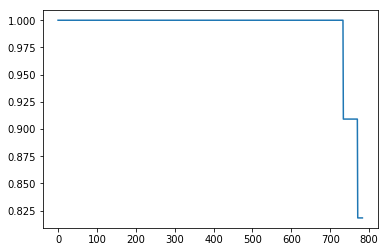

In [216]:
plt.plot(x[0][:])

In [217]:
x.shape

(1, 784)

In [218]:
result = model.predict(x)

In [219]:
len(result)

1

In [209]:
help(model)

Help on Sequential in module tensorflow.python.keras.engine.sequential object:

class Sequential(tensorflow.python.keras.engine.training.Model)
 |  Sequential(layers=None, name=None)
 |  
 |  Linear stack of layers.
 |  
 |  Arguments:
 |      layers: list of layers to add to the model.
 |  
 |  Example:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dens

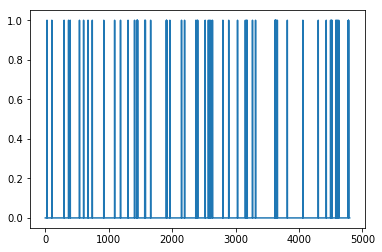

In [220]:
plt.plot(y_train)

In [222]:
np.mean(y_train)

0.0125

In [223]:
result = model.predict(X_train)

In [224]:
result

array([[0.00312996],
       [0.33886862],
       [0.00101224],
       ...,
       [0.00101224],
       [0.00622189],
       [0.00351337]], dtype=float32)

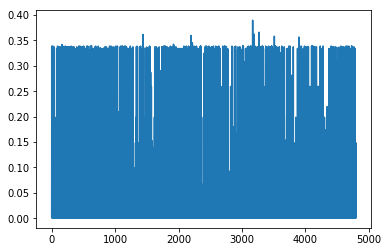

In [227]:
plt.plot(result)

In [419]:
index = 367

In [420]:
x=X_train[index][:]
x=np.tile(x,(1,1))

In [421]:
x.shape

(1, 784)

In [422]:
y_train[index]

1.0

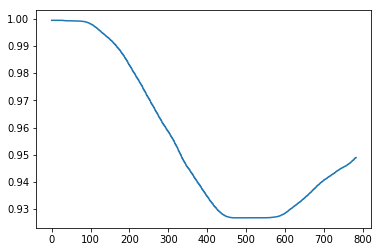

In [423]:
plt.plot(x[0])

In [425]:
model.predict(x)

array([[0.00101224],
       [0.00106657],
       [0.01128092],
       ...,
       [0.00101224],
       [0.33420548],
       [0.00101224]], dtype=float32)

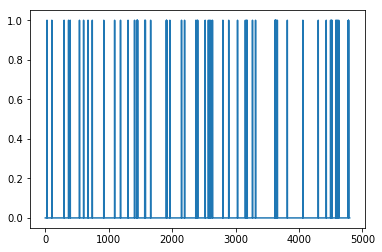

In [406]:
plt.plot(y_train)

In [398]:
steering_samples_indexes = np.where(y_train==1)

In [397]:
np.where(y_train==1)

(array([  27,  103,  297,  367,  393,  539,  604,  674,  741,  922, 1093,
        1186, 1305, 1407, 1441, 1452, 1454, 1568, 1578, 1661, 1909, 1914,
        1964, 2148, 2196, 2373, 2393, 2403, 2521, 2571, 2589, 2609, 2636,
        2800, 2892, 3031, 3154, 3172, 3183, 3267, 3315, 3621, 3626, 3627,
        3629, 3645, 3659, 3816, 4061, 4304, 4430, 4498, 4512, 4519, 4580,
        4594, 4609, 4627, 4779, 4781]),)

In [ ]:
x=X_train[index][:]
x=np.tile(x,(1,1))

In [428]:
predictions = model.predict(X_train)

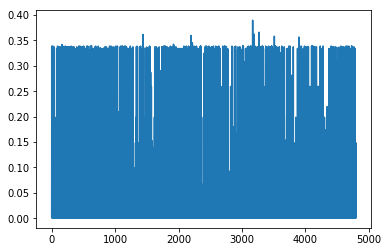

In [429]:
plt.plot(predictions)

In [ ]:
# Issue samples are almost always non steering so model just 